In [9]:
from pathlib import Path
from os import listdir
from os.path import isfile, join
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

# Obtain Data

In [2]:
root_dir = Path(os.getcwd())
feature_path = root_dir/'feature_database'
text_path = root_dir/'short_text_database'

In [89]:
sample_word = 'off'
feature_samples = [feature_path/word/f for f in listdir(feature_path/word) if isfile(join(feature_path/word, f)) and f.endswith('.csv')]
text_samples = [text_path/word/f for f in listdir(text_path/word) if isfile(join(text_path/word, f)) and f.endswith('.csv')]

# Formant Feature Extraction

In [162]:
def get_formant_features(feature_sample_path):
    db = pd.read_csv(feature_sample_path)
    
    # Only Take sounding portion from Voice Activity Recognition
    sound_db = db[db[' phoneme']=='sounding'].replace(to_replace='--undefined--', value=0)
    sound_db[' F1'] = pd.to_numeric(sound_db[' F1'], downcast='float')
    sound_db[' F2'] = pd.to_numeric(sound_db[' F2'], downcast='float')
    sound_db[' F3'] = pd.to_numeric(sound_db[' F3'], downcast='float')
    
    # Extract raw features in Hz of the sounding portion
    f1_og = sound_db[' F1'].to_numpy(dtype='float')
    f2_og = sound_db[' F2'].to_numpy(dtype='float')
    f3_og = sound_db[' F3'].to_numpy(dtype='float')
    
    return f1_og, f2_og, f3_og

In [163]:
def plot_formant_features(f1_og, f2_og, f3_og, ax=plt):
    ax.plot(f1_og, label = 'F1')
    ax.plot(f2_og, label = 'F2')
    ax.plot(f3_og, label = 'F3')

    ax.legend()
    if (ax == plt):
        ax.show()

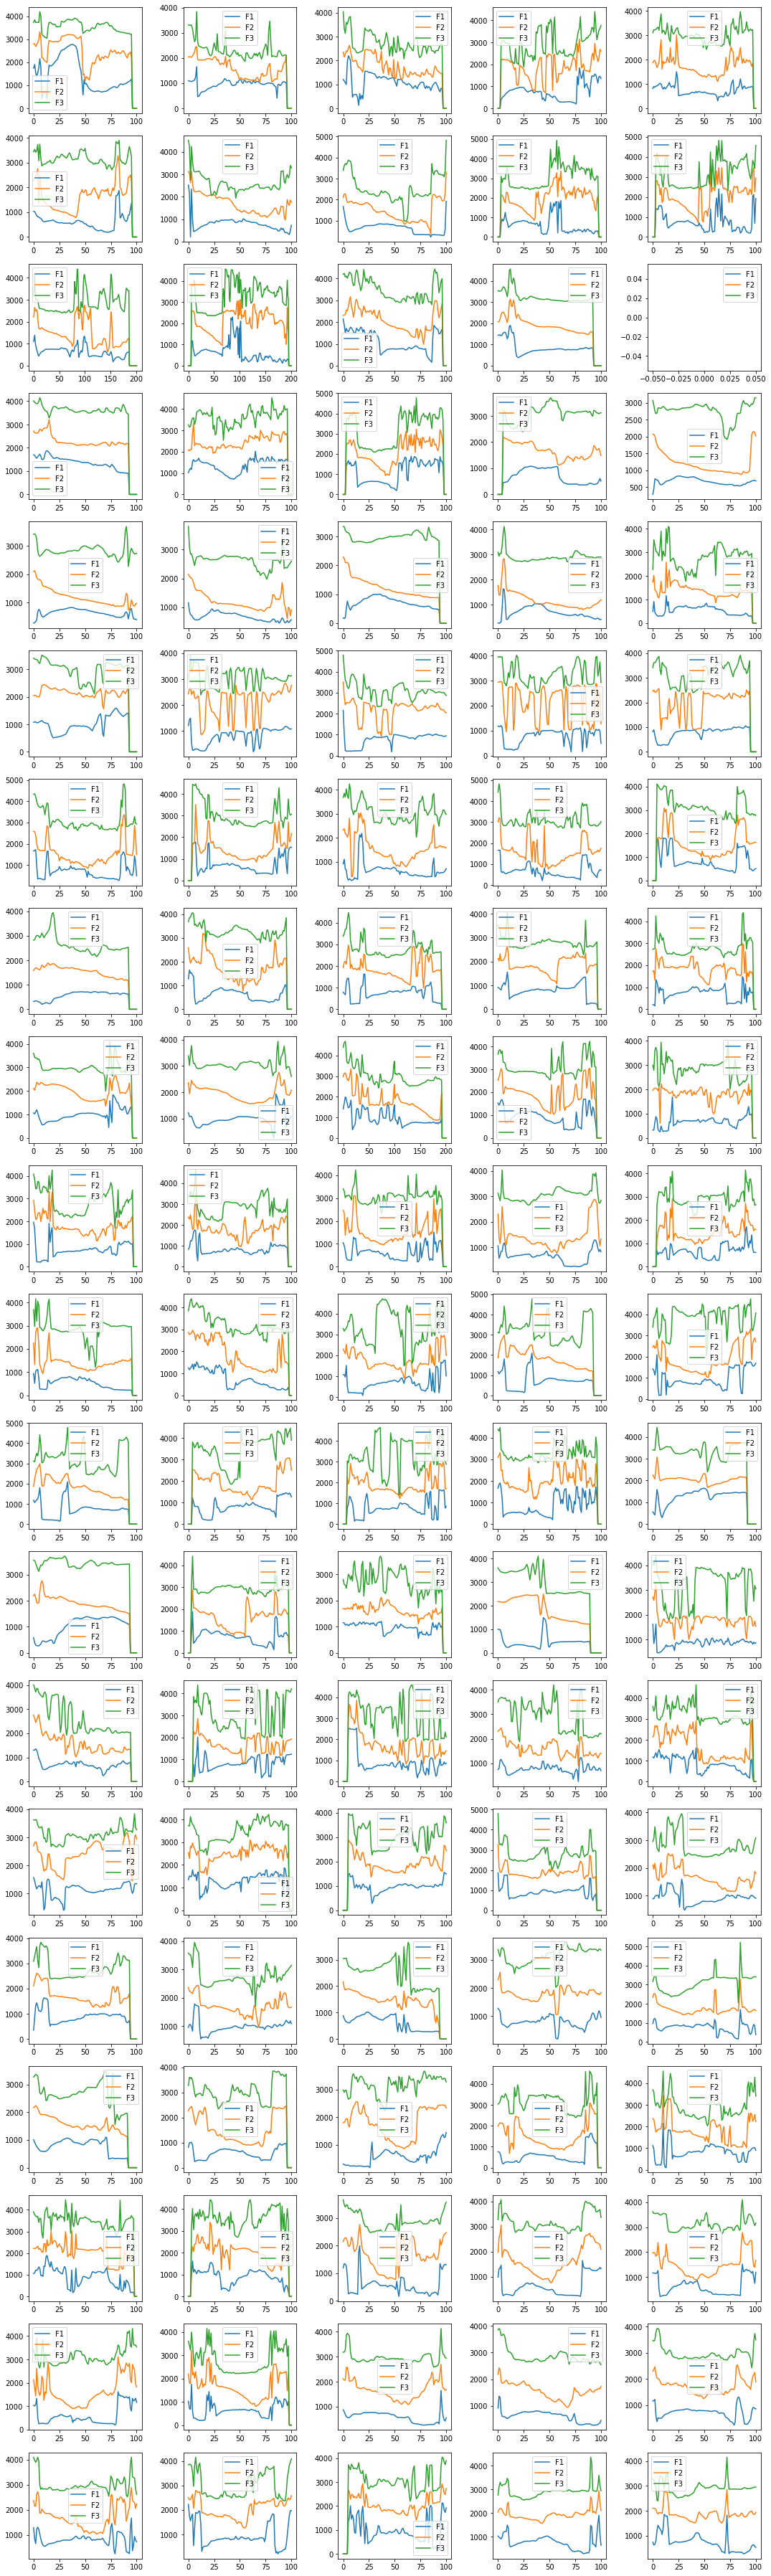

In [7]:
nrows=20
ncols=5
figure, ax = plt.subplots(nrows, ncols, figsize=(15,50))

for i in range(nrows):
    for j in range(ncols):
        f1_og, f2_og, f3_og = get_formant_features(feature_samples[i*ncols + j])
        plot_formant_features(f1_og, f2_og, f3_og, ax[i,j])

figure.tight_layout()

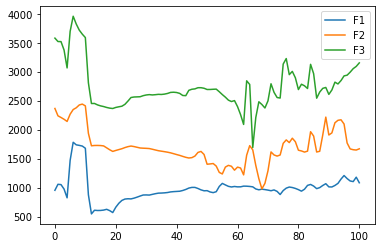

In [8]:
f1_og, f2_og, f3_og = get_formant_features(feature_samples[76])
plot_formant_features(f1_og, f2_og, f3_og)

## TODO:
- Feature formant ideas:
    - Difference between formants
    - Formant values themselves (look at if they slope up or down?)
    - Only look at the "voiced" sections

# Spectrogram Feature Extraction

In [128]:
def get_spectrogram(text_sample_path):
    stdb = pd.read_csv(text_sample_path)

    stdb = stdb.rename(columns={'File type = "ooTextFile"': 'val'})
    stdb_data = stdb.iloc[11:,:]

    nx = int(stdb.iloc[8]['val'])
    ny = int(stdb.iloc[3]['val'])

    new_spectrogram = np.array([[0]*ny]*nx, dtype='float')
    for x in range(nx):
        new_spectrogram[x] = stdb_data.iloc[x*ny:x*ny+ny].squeeze().to_numpy(dtype='float')

    # Adding minuscule quantity to spectrogram to avoid log(0)
    new_spectrogram += 0.0000000001
        
    log_new_spectrogram = np.log(new_spectrogram)
    
    # make everything positive (a bit hacky)
    if (np.min(new_spectrogram) < 0):
        new_spectrogram += -np.min(new_spectrogram)
    if (np.min(log_new_spectrogram) < 0):
        log_new_spectrogram += np.abs(np.min(log_new_spectrogram))

    return new_spectrogram, log_new_spectrogram

In [129]:
def plot_spectrogram(log_new_spectrogram, ax=plt):
        ax.imshow(log_new_spectrogram, origin='lower')

        if (ax==plt):
            ax.show()

In [130]:
# GET ALL SPECTROGRAMS
words = ['on', 'off', 'go', 'stop', 'left', 'right', 'yes', 'no', 'up', 'down']

spectrograms = {}
log_spectrograms = {}

for i in words:
    spectrograms[i] = []
    
for i in words:
    log_spectrograms[i] = []

for word in words:
    w_text_samples = [text_path/word/f for f in listdir(text_path/word) if isfile(join(text_path/word, f)) and f.endswith('.csv')]
    for t in w_text_samples:
        curr_new_spectrogram, curr_log_new_spectrogram = get_spectrogram(t)
        spectrograms[word].append(curr_new_spectrogram)
        log_spectrograms[word].append(curr_log_new_spectrogram)
        
    print("Finished Collecting", word)

<ipython-input-128-440c8f78d2d6>:17: RuntimeWarning: invalid value encountered in log
  log_new_spectrogram = np.log(new_spectrogram)


Finished Collecting on
Finished Collecting off
Finished Collecting go
Finished Collecting stop
Finished Collecting left
Finished Collecting right
Finished Collecting yes
Finished Collecting no
Finished Collecting up
Finished Collecting down


# Spectrogram Feature Exploration

In [137]:
word = 'on'

In [132]:
def get_plot_range_amplitudes(log_new_spectrogram, ax=plt, plot=True):
    # 192 - 6000 Hz
    # 80 - 2500 Hz Lower threshold for [s] sounds
    # 41 - 1300 Hz Range for [n] or noise, unfortunately

    f_base = 0
    f_fund_limit = 41
    f_low = 80
    f_high = 192

    window = 15

    fund_range_spectrogram = log_new_spectrogram[f_base:f_fund_limit]
    low_range_spectrogram = log_new_spectrogram[f_fund_limit:f_low]
    high_range_spectrogram = log_new_spectrogram[f_low:f_high]
    fund_range_amplitude = np.sum(fund_range_spectrogram, axis=0) * (1 / (f_fund_limit - f_base + 1))
    low_range_amplitude = np.sum(low_range_spectrogram, axis=0) * (1 / (f_low - f_fund_limit + 1))
    high_range_amplitude = np.sum(high_range_spectrogram, axis=0) * (1 / (f_high - f_low + 1))
#     fund_range_spectrogram = new_spectrogram[f_base:f_fund_limit]
#     low_range_spectrogram = new_spectrogram[f_fund_limit:f_low]
#     high_range_spectrogram = new_spectrogram[f_low:f_high]
#     fund_range_amplitude = np.log(np.sum(fund_range_spectrogram, axis=0)  * (1 / (f_fund_limit - f_base + 1)))
#     low_range_amplitude = np.log(np.sum(low_range_spectrogram, axis=0) * (1 / (f_low - f_fund_limit + 1)))
#     high_range_amplitude = np.log(np.sum(high_range_spectrogram, axis=0) * (1 / (f_high - f_low + 1)))


    # Filter to smooth signals
    fund_range_amplitude = np.convolve(fund_range_amplitude, np.ones(window), 'valid') / window
    low_range_amplitude = np.convolve(low_range_amplitude, np.ones(window), 'valid') / window
    high_range_amplitude = np.convolve(high_range_amplitude, np.ones(window), 'valid') / window
    
    # Normalize
    min_val = np.min([np.min(fund_range_amplitude), np.min(low_range_amplitude), np.min(high_range_amplitude)])
    max_val = np.max([np.max(fund_range_amplitude), np.max(low_range_amplitude), np.max(high_range_amplitude)])
    fund_range_amplitude = (fund_range_amplitude - min_val) / (max_val - min_val)
    low_range_amplitude = (low_range_amplitude - min_val) / (max_val - min_val)
    high_range_amplitude = (high_range_amplitude - min_val) / (max_val - min_val)
#     f_min = np.min(fund_range_amplitude)
#     f_max = np.max(fund_range_amplitude)
#     l_min = np.min(low_range_amplitude)
#     l_max = np.max(low_range_amplitude)
#     h_min = np.min(high_range_amplitude)
#     h_max = np.max(high_range_amplitude)
#     fund_range_amplitude = (fund_range_amplitude - f_min) / (f_max - f_min)
#     low_range_amplitude = (low_range_amplitude - l_min) / (l_max - l_min)
#     high_range_amplitude = (high_range_amplitude - h_min) / (h_max - h_min)

    if (plot==True):
        ax.plot(fund_range_amplitude, label='famp')
        ax.plot(low_range_amplitude, label='lamp')
        ax.plot(high_range_amplitude, label='hamp')

        ax.legend()
        if (ax==plt):
            ax.show()
        
    return fund_range_amplitude, low_range_amplitude, high_range_amplitude

In [133]:
def get_plot_amplitude_features(fund_range_amplitude, low_range_amplitude, high_range_amplitude, ax=plt, plot=True):
    high_minus_low = high_range_amplitude - low_range_amplitude
    
    if (plot==True):
        ax.plot(high_minus_low, label='hml')

        ax.legend()
        if (ax==plt):
            ax.show()

    return high_minus_low

In [135]:
def get_f_indicator(log_new_spectrogram, ax=plt, plot=True):
    # HIGH column_averages and LOW mean_dist_from_avg indicate the letter F!!
    column_averages = np.mean(log_new_spectrogram, axis=0)
    distances_from_average = np.subtract(log_new_spectrogram, column_averages)
    mean_dist_from_avg = np.mean(np.abs(distances_from_average), axis=0)
    
    if (plot==True):
        ax.plot(mean_dist_from_avg, label='mdfa')
        ax.plot(column_averages, label='ca')

        ax.legend()
        if (ax==plt):
            ax.show()

    return mean_dist_from_avg

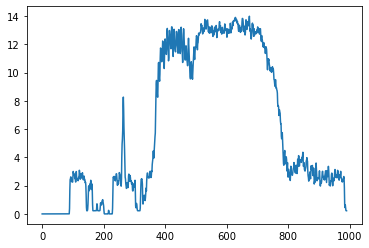

In [125]:
plt.plot(ca)

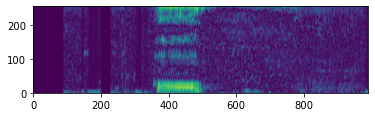

In [123]:
plt.imshow(np.abs(dfa), origin='lower')

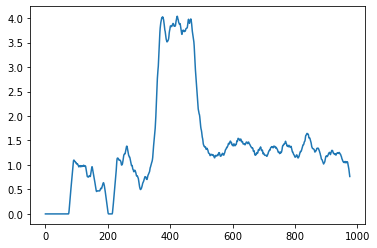

In [127]:
a , test = get_spectrogram(text_samples[5])
ca = np.mean(test, axis=0)
dfa = np.subtract(test, ca)
mdfa = np.mean(np.abs(dfa), axis=0)
mdfa = np.convolve(mdfa, np.ones(15), 'valid') / 15
plt.plot(mdfa)
# HIGH CA and LOW MDFA indicate the letter F!!

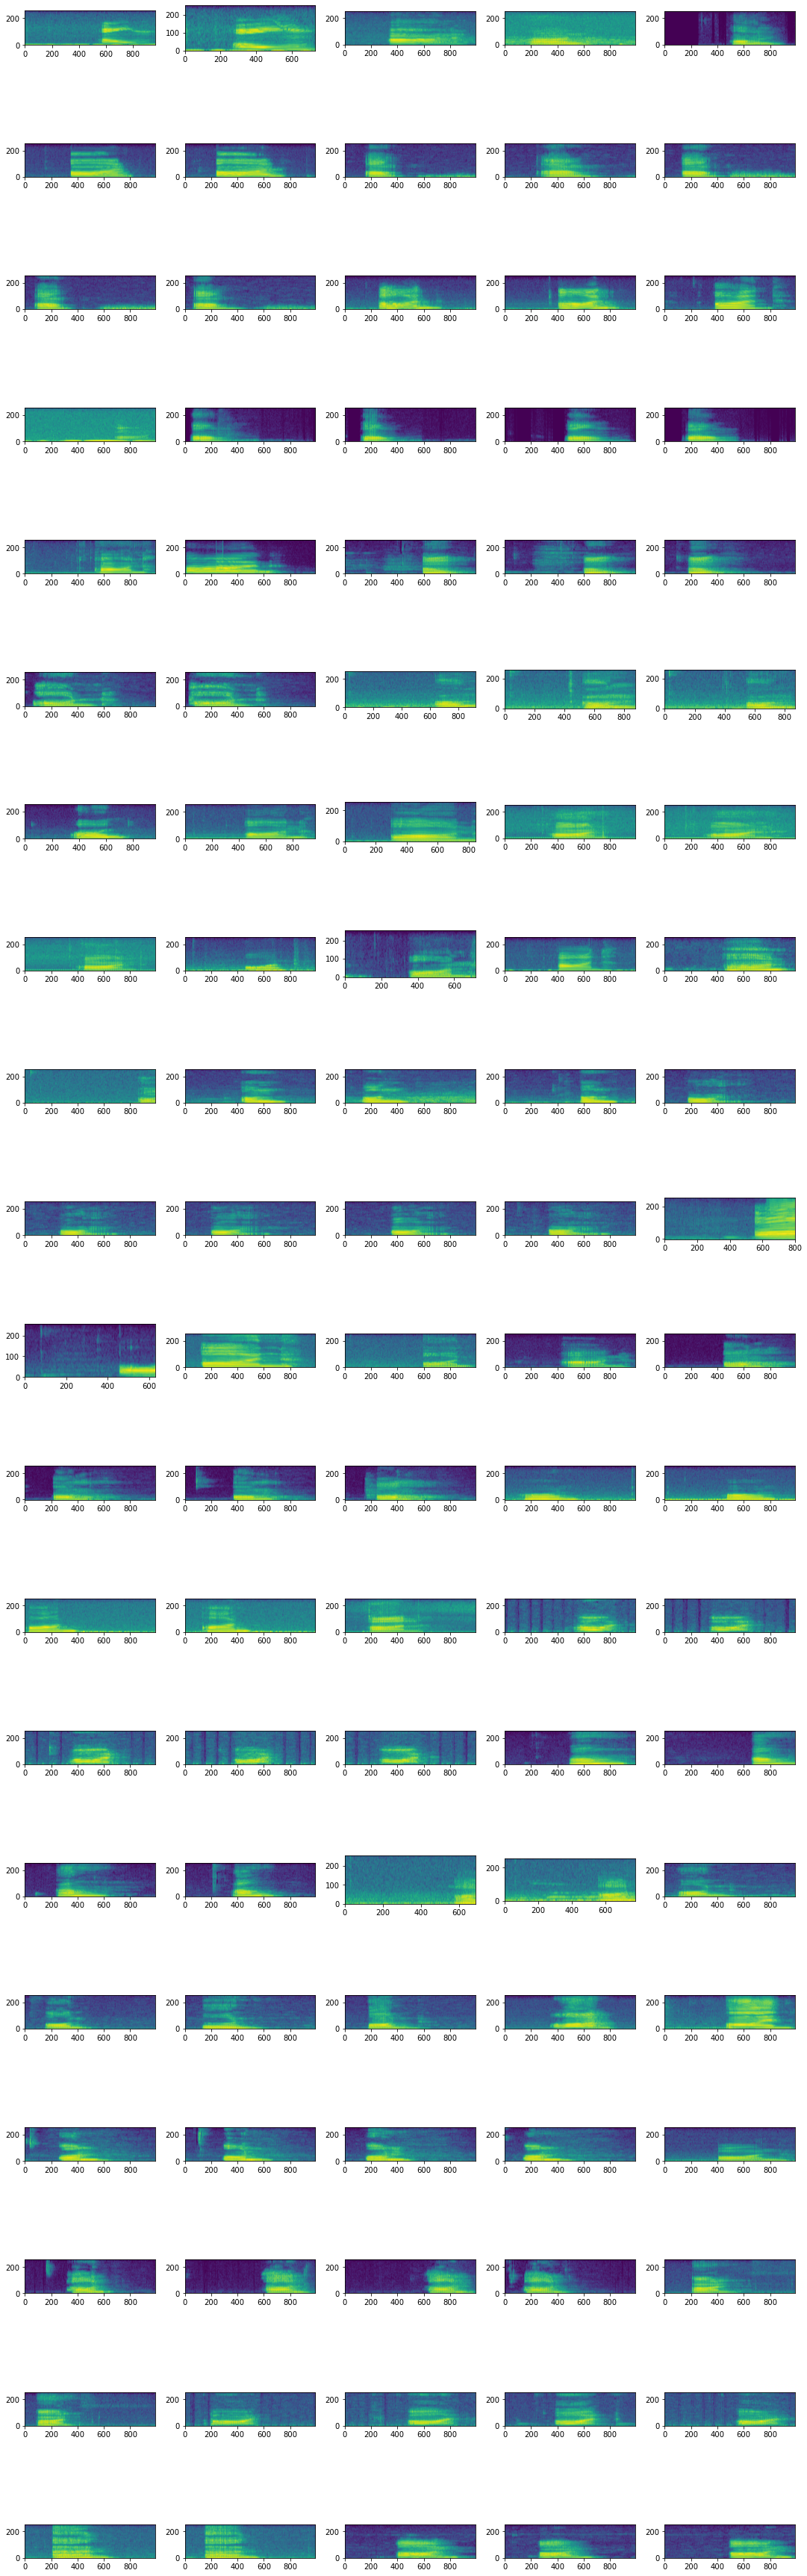

In [138]:
nrows=20
ncols=5
figure, ax = plt.subplots(nrows, ncols, figsize=(15,50))

for i in range(nrows):
    for j in range(ncols):
        plot_spectrogram(log_spectrograms[word][i*ncols + j], ax[i,j])

figure.tight_layout()

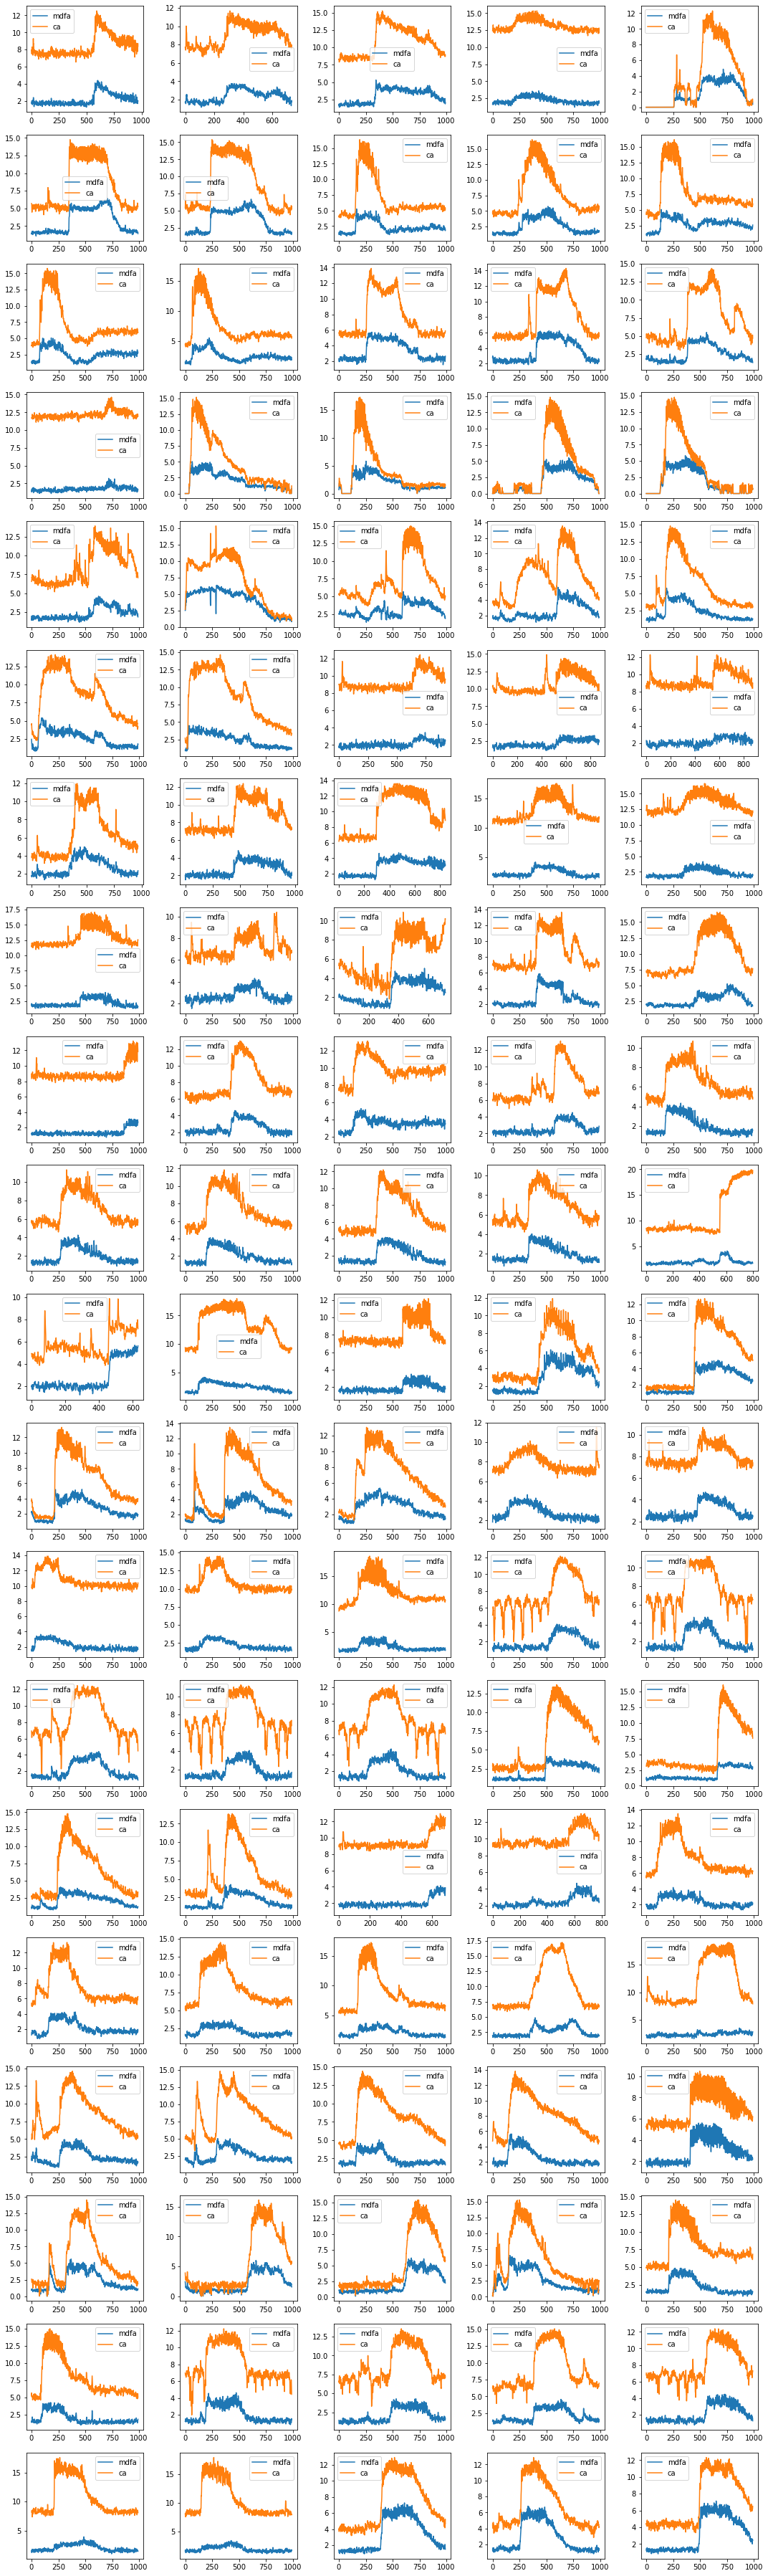

In [139]:
nrows=20
ncols=5
figure, ax = plt.subplots(nrows, ncols, figsize=(15,50))

for i in range(nrows):
    for j in range(ncols):
#         _, _, _ = get_plot_range_amplitudes(log_spectrograms[word][i*ncols + j], ax[i,j])
        _ =  get_f_indicator(log_spectrograms[word][i*ncols + j], ax[i,j])
    
figure.tight_layout()

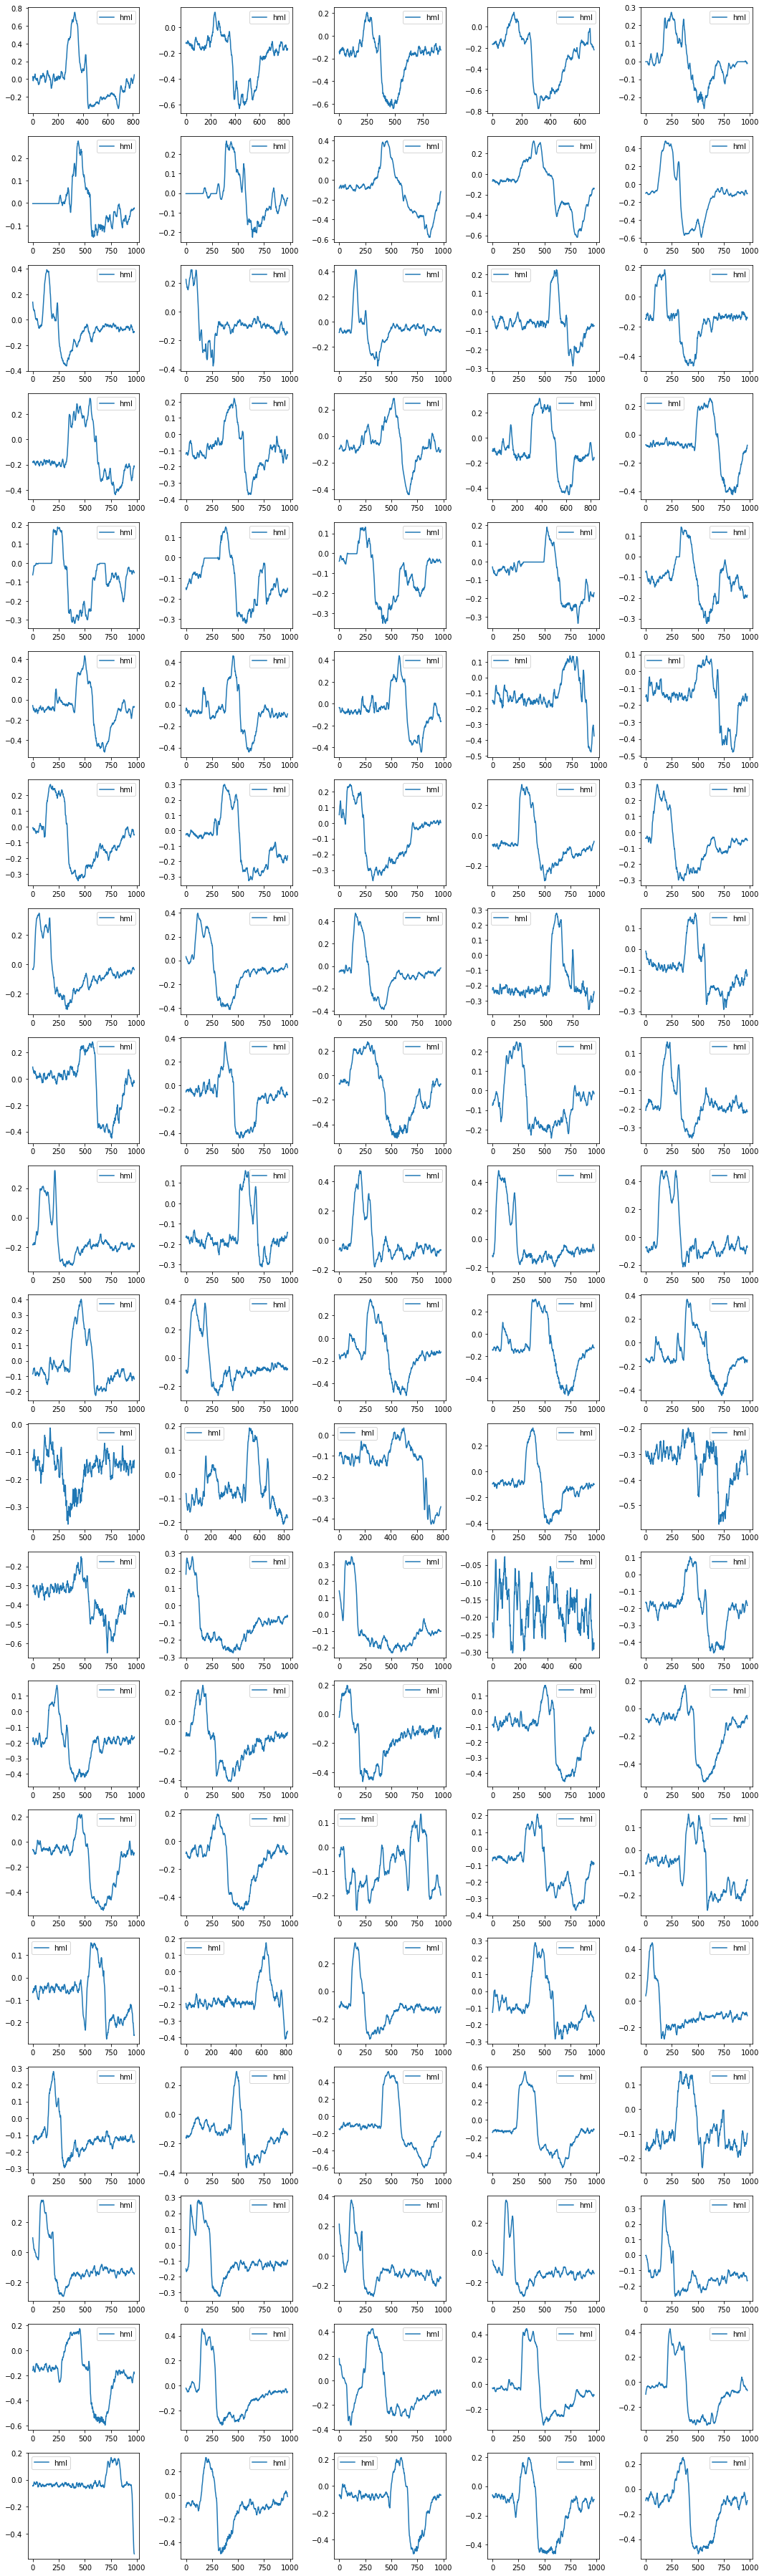

In [122]:
nrows=20
ncols=5
figure, ax = plt.subplots(nrows, ncols, figsize=(15,50))

for i in range(nrows):
    for j in range(ncols):
        new_spectrogram, log_new_spectrogram = get_spectrogram(text_samples[i*ncols + j], plot=False)
        fund_range_amplitude, low_range_amplitude, high_range_amplitude = get_plot_range_amplitudes(new_spectrogram, ax[i,j], plot=False)
        _ = get_plot_amplitude_features(fund_range_amplitude, low_range_amplitude, high_range_amplitude, ax[i,j])

figure.tight_layout()

In [16]:
def get_plot_voicing(new_spectrogram, ax=plt, plot=True):
    # 160 - 5000 Hz
    # 3 - 90 Hz
    # 25 - 800 Hz

    f_fund_low = 3
    f_fund_high = 25
    num_harmonics = 5

    volume_offset_spectrogram = log_new_spectrogram[0:num_harmonics*f_fund_high]
    volume_offset_amplitude = (1/(num_harmonics*f_fund_high+1)) * np.sum(volume_offset_spectrogram, axis=0)

    voicing_amplitude = np.array([0]*log_new_spectrogram[0].shape[0], dtype='float64')
    f_fund = 0
    for f in range(f_fund_low, f_fund_high):
        test_voicing_amplitude = np.array([0]*log_new_spectrogram[0].shape[0], dtype='float64')
        for i in range(1, num_harmonics+1):
            test_voicing_amplitude += (log_new_spectrogram[i*f]) # This is what the paper did, but maybe isn't good (log_new_spectrogram[i*f] - volume_offset_amplitude)
        # Normalize
        max_val = np.quantile(test_voicing_amplitude, 1)
        min_val = np.quantile(test_voicing_amplitude, 0)
        test_voicing_amplitude = (test_voicing_amplitude - min_val) / (max_val - min_val)
        # Find f that gives the greatest magnitude
        curr_sum = np.sum(test_voicing_amplitude)
        if (curr_sum > np.sum(voicing_amplitude)):
            voicing_amplitude = test_voicing_amplitude
            f_fund = f
            
    if (plot==True):
        ax.plot(voicing_amplitude, label='Voicing Amplitude at F_0 = {f}'.format(f=f_fund))

        ax.legend()
        if (ax==plt):
            ax.show()

    return voicing_amplitude

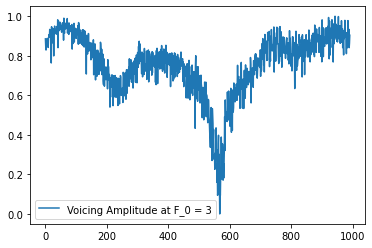

In [17]:
voicing_amplitude = get_plot_voicing(new_spectrogram)

In [22]:
def smooth_plot_voicing(voicing_amplitude, window, ax=plt, plot=True):
    smooth_voicing_amplitude = np.convolve(voicing_amplitude, np.ones(window), 'valid') / window
    
    if (plot==True):
        ax.plot(smooth_voicing_amplitude, label='Smooth Voicing')
        
        ax.legend()
        if (ax==plt):
            ax.show()

    return smooth_voicing_amplitude

In [18]:
def discretize_plot_voicing(voicing_amplitude, threshold, ax=plt, plot=True):
    discrete_voicing = np.where(voicing_amplitude > threshold, 1, 0) # threshold between 0-1. Usually 0.7
    
    if (plot==True):
        ax.plot(discrete_voicing, label='Discrete Voicing')
        
        ax.legend()
        if (ax==plt):
            ax.show()

    return discrete_voicing

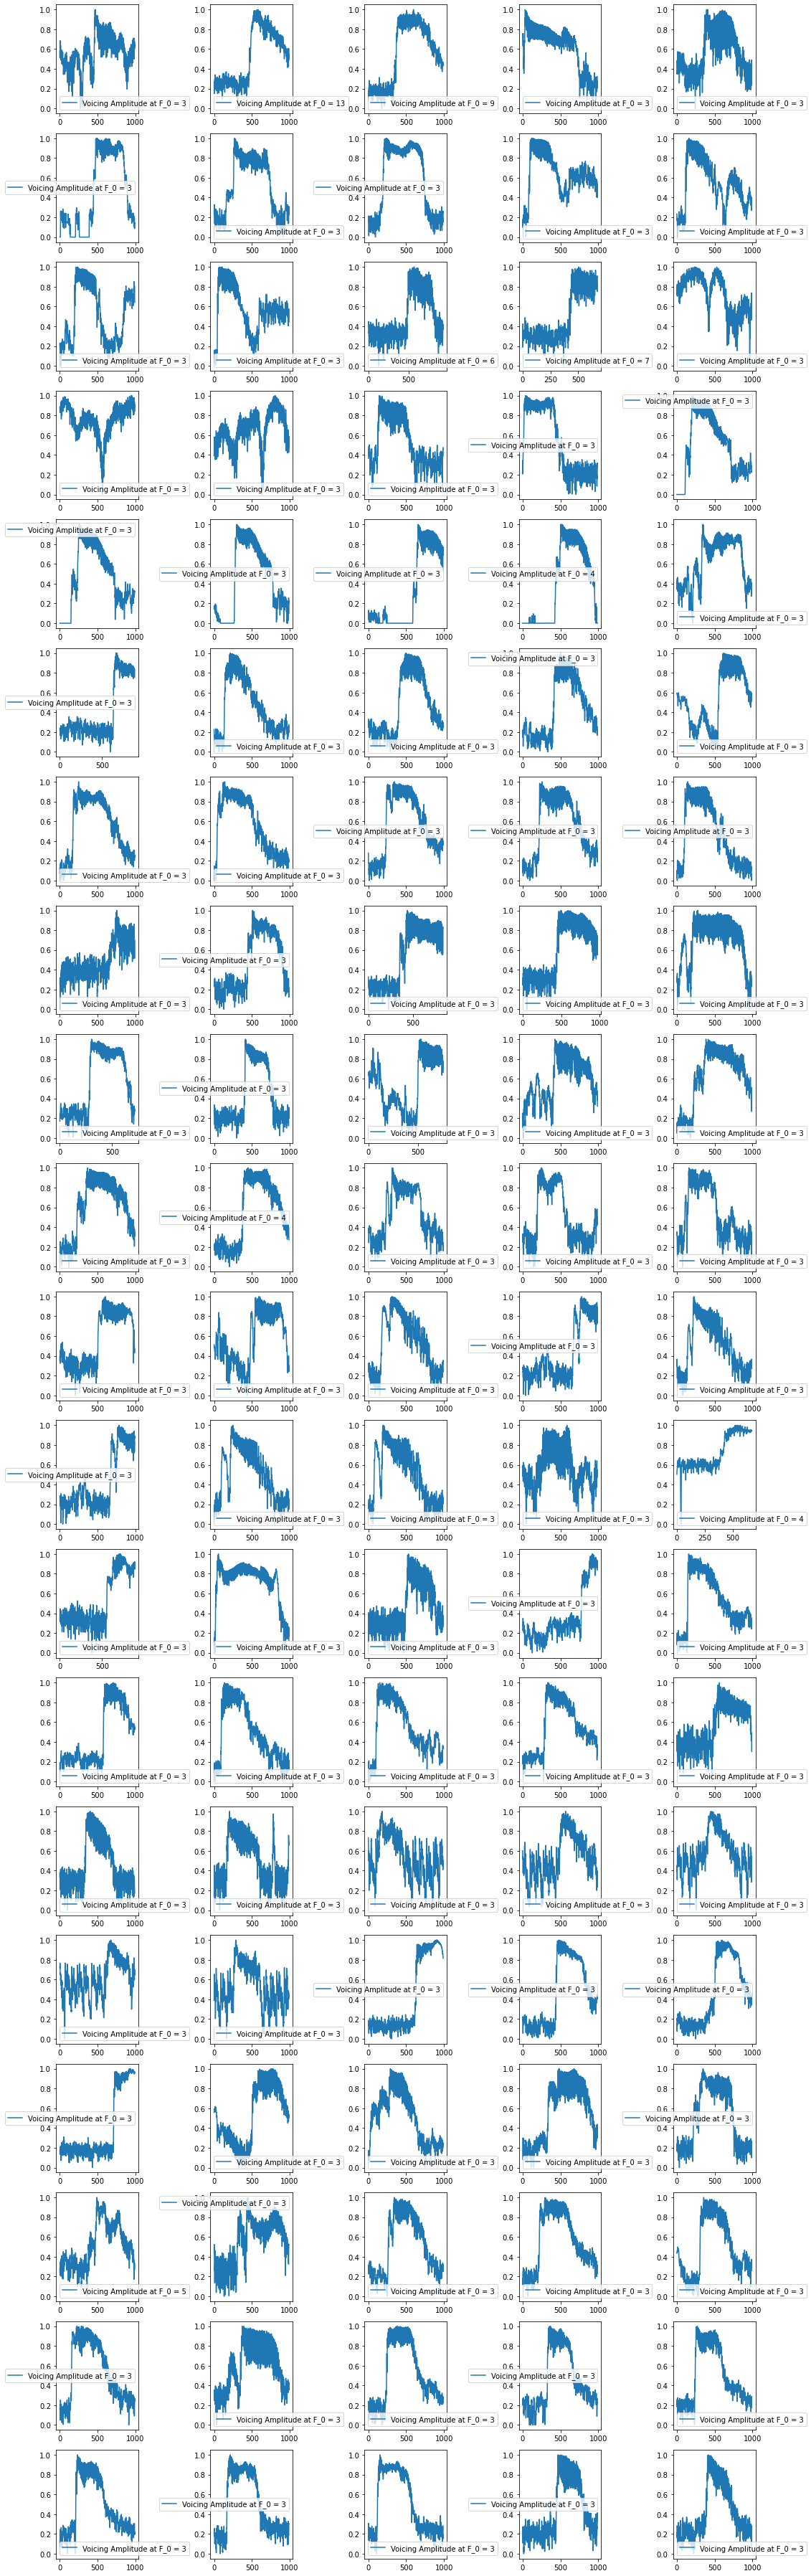

In [19]:
nrows=20
ncols=5
figure, ax = plt.subplots(nrows, ncols, figsize=(15,50))

for i in range(nrows):
    for j in range(ncols):
        new_spectrogram, log_new_spectrogram = get_spectrogram(text_samples[i*ncols + j], plot=False)
        voicing_amplitude = get_plot_voicing(new_spectrogram, ax[i,j])

figure.tight_layout()

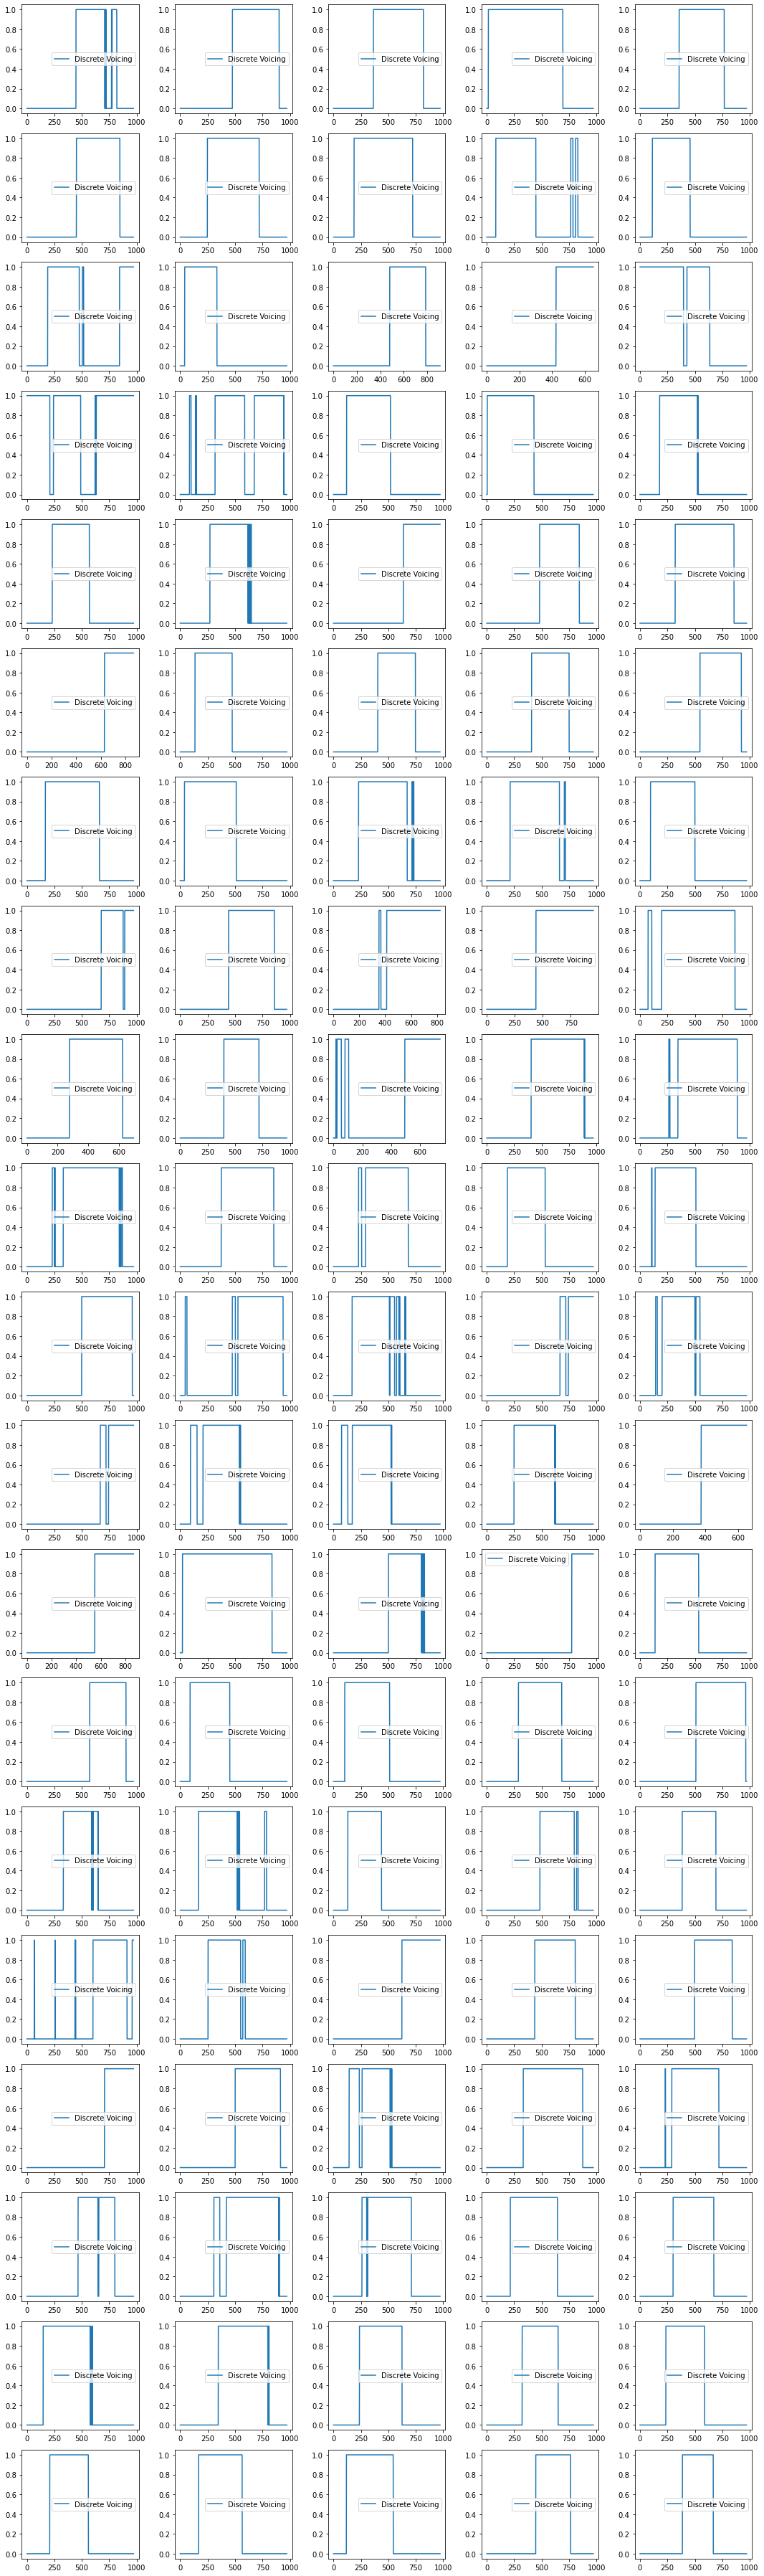

In [27]:
nrows=20
ncols=5
figure, ax = plt.subplots(nrows, ncols, figsize=(15,50))

for i in range(nrows):
    for j in range(ncols):
        new_spectrogram, log_new_spectrogram = get_spectrogram(text_samples[i*ncols + j], plot=False)
        voicing_amplitude = get_plot_voicing(new_spectrogram, ax[i,j], plot=False)
        smooth_voicing_amplitude = smooth_plot_voicing(voicing_amplitude, 20, ax[i,j], plot=False)
        discrete_voicing = discretize_plot_voicing(smooth_voicing_amplitude, 0.65, ax[i,j], plot=True)

figure.tight_layout()

## TODO
- Make obtaining spectrograms computationally faster, then plot the voicing and amplitudes for different words for exploration.
    - Might want to get 6KHz images, and tune the frequency ranges.
- Looks like to detect [s], we specifically want to check the difference between in range and out range amplitude, where in range should be bigger. Might need to increase frequencies to 6KHz to see a more clear [s] amplitude difference.
- Detecting [n] might also come from seeing when the bottom range amplitude is greater than top range amplitude, since [n] mostly occupies very low frequencies!

# Plan
- Make obtaining spectrograms faster so we can get batches of them (DONE)
- NEXT TASK: We have a clever way of detecting [f]!. Make it a bit more clean (low-pass filter) and normalize ca and mdfa a bit better. Then test to see if it is also not visible with other words.
- Mask the formant features
    - Tried slope of voicing_amplitude, but that doesn't look helpful. Will try to threshold at 0.6, set everything above to 1, everything below to 0, then multiply with formants
    - To do this, will need to find the biggest range of 1s
- Analyze resulting formant features, and see what operations to do with them to distinguish them best